In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import InceptionResNetV2

In [3]:
import numpy as np 
import pandas as pd
import json
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

list_dir = os.listdir(os.path.join(WORK_DIR, "train_images"))
print(len(list_dir))
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=2))
    
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

train = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train['label'] = train['label'].astype('string')
train.head()

diseases = pd.read_json("/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json", typ='series')
diseases
train['label'].value_counts(normalize=True)
IMG_SIZE = 320

21397
{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


In [4]:
IMG_SIZE = 300

datagen = image.ImageDataGenerator(rotation_range=360,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                brightness_range=[0.2,1.5],
                                shear_range=25,
                                zoom_range=0.3,
                                channel_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1/255,
                                validation_split=0.15)

val_datagen = image.ImageDataGenerator(rescale=1/255,
                                       validation_split = 0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/cassava-leaf-disease-classification/train_images",
    x_col='image_id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    subset='training',
    shuffle = True,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/cassava-leaf-disease-classification/train_images",
    x_col='image_id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    subset='validation',
    class_mode = 'categorical',
    shuffle = True
)
train_imgs, labels = next(train_generator)
print(train_imgs.shape)

Found 18188 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
(32, 300, 300, 3)


(32, 300, 300, 3)


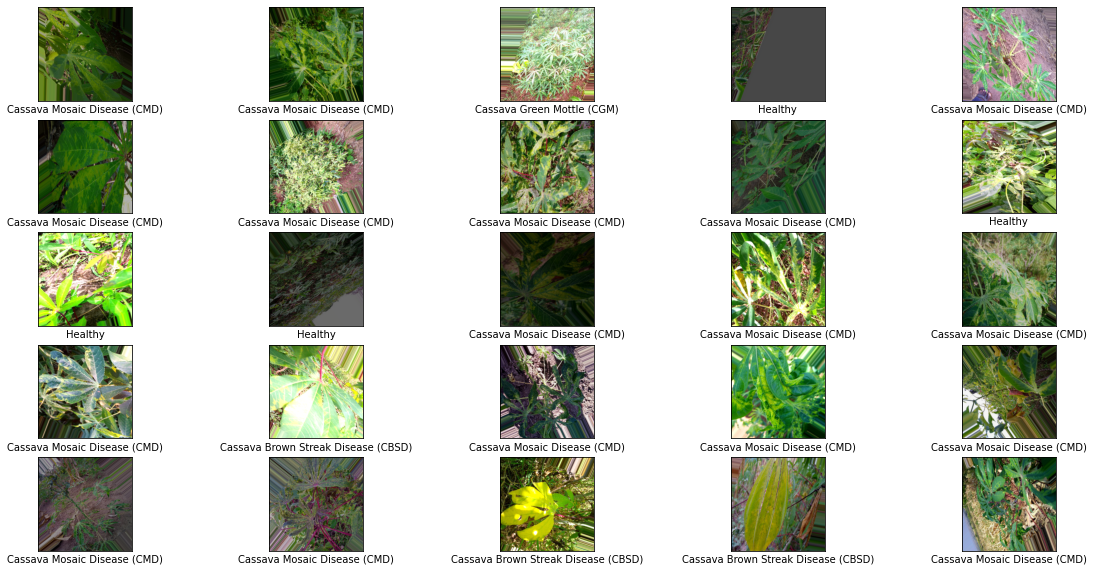

In [5]:
plt.figure(figsize=(20,10))
train_imgs, labels = next(train_generator)
print(train_imgs.shape)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_imgs[i])
    label1 = np.argmax(labels[i])
    plt.xlabel(diseases.get(label1))
plt.show()

In [6]:
print(train_imgs[0].shape)
print(labels[0])


(300, 300, 3)
[0. 0. 0. 1. 0.]


87916544/87910968 [==============================] - 3s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
568/568 [==============================] - 735s 1s/step - loss: 1.2176 - acc: 0.6022 - val_loss: 69.4516 - val_acc: 0.2669

Epoch 00001: val_loss improved from inf to 69.45161, saving model to Model
Epoch 2/15
568/568 [==============================] - 639s 1s/step - loss: 0.9571 - acc: 0.6507 - val_loss: 1.2370 - val_acc: 0.4579

Epoch 00002: val_loss improved from 69.45161 to 1.23705, saving model to Model
Epoch 3/15
568/568 [==============================] - 629s 1s/step - loss: 0.8555 - acc: 0.6845 - val_loss: 1.3248 - val_acc: 0.3891

Epoch 00003: val_loss did not improve from 1.23705
Epoch 4/15
568/568 [==============================] - 634s 1s/step - loss: 0.7441 - acc: 0.7338 - val_loss: 0.9353 - val_acc: 0.6325

Epoch 00004: val_loss improved from 1.23705 to 0.93532, saving model to Model
Epoch 5/15
568/568 [==============================] - 633s 1s/step - loss: 0.6895 - acc: 0.7635 - val_loss: 0.6045 - val_acc: 0.7857

Epoch 00005: val_loss improved from 0.93532 to

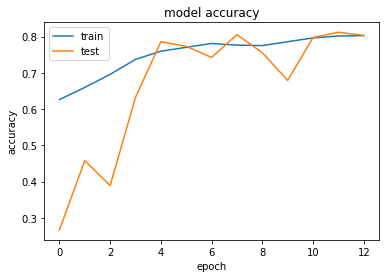

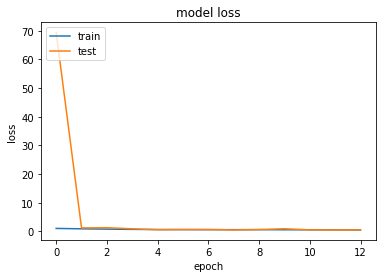

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = InceptionV3(weights='imagenet', include_top=False)
#base_model = VGG19(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#for layer in base_model.layers:
 #   layer.trainable = False

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
model.compile(optimizer = opt,
              loss ='categorical_crossentropy',
              metrics = ['acc'])
model_save = ModelCheckpoint("Model", 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

history = model.fit_generator(train_generator, steps_per_epoch=18188//32, epochs=15,
                              validation_data=val_generator, validation_steps = 4279//32,
                             callbacks = [model_save, early_stop])

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
model.save('model.h5')

In [13]:
model.save('modelv2.h5')

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.GaussianDropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])